In [1]:
!pip install -q --upgrade transformers==4.25.1 diffusers ftfy accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.9/93.9 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 39.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 336.4/336.4 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 29.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sentence-transformers 3.2.1 requires transformers<5.0.0,>=4.41.0, but you have transformers 4.25.1 which is incompatible.


In [2]:
import argparse, itertools, math, os, random
import numpy as np, torch, torch.nn.functional as F, torch.utils.checkpoint
from torch.utils.data import Dataset, DataLoader

from accelerate import Accelerator
from accelerate.logging import get_logger
from accelerate.utils import set_seed
from diffusers import AutoencoderKL, DDPMScheduler, PNDMScheduler, StableDiffusionPipeline, UNet2DConditionModel
from diffusers.optimization import get_scheduler
from diffusers.pipelines.stable_diffusion import StableDiffusionSafetyChecker
from PIL import Image
from PIL.Image import Resampling
from torchvision import transforms
from tqdm.auto import tqdm

from transformers import CLIPFeatureExtractor, CLIPTextModel, CLIPTokenizer
import fastcore.all as fc
from huggingface_hub import Repository
from pathlib import Path

import torchvision.transforms.functional as tf
import accelerate

import os
import gdown
import zipfile

import pandas as pd
import shutil


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


Moving 0 files to the new cache system


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


0it [00:00, ?it/s]

In [5]:
# URL do arquivo no Google Drive
url = "https://drive.google.com/uc?id=1O-Il4feenj_WFIqTdKNn4gGRBgTBgbO-"

# Nome do arquivo a ser salvo
output = "dataset.zip"

# Baixar o arquivo
gdown.download(url, output, quiet=False)

# Verificar se o arquivo é ZIP e descompactar
if zipfile.is_zipfile(output):
    with zipfile.ZipFile(output, 'r') as zip_ref:
        # Criar um diretório para extrair os arquivos
        extract_path = "extracted_data"
        os.makedirs(extract_path, exist_ok=True)
        zip_ref.extractall(extract_path)
        print(f"Arquivos extraídos para: {extract_path}")
else:
    print("O arquivo baixado não é um arquivo ZIP.")

Downloading...
From (original): https://drive.google.com/uc?id=1O-Il4feenj_WFIqTdKNn4gGRBgTBgbO-
From (redirected): https://drive.google.com/uc?id=1O-Il4feenj_WFIqTdKNn4gGRBgTBgbO-&confirm=t&uuid=8cae6f84-4c0e-4eed-bc18-eec0f506ae74
To: /content/dataset.zip
100%|██████████| 8.25G/8.25G [02:16<00:00, 60.6MB/s]


Arquivos extraídos para: extracted_data


In [37]:
# Função para processar os metadados das imagens
def process_image_metadata(images_folder):
    """
    Processa os nomes das imagens em uma pasta para extrair informações sobre tipo e status do desastre.

    Args:
        images_folder (str): Caminho para a pasta contendo as imagens.

    Returns:
        pd.DataFrame: DataFrame contendo metadados das imagens.
    """
    data = []
    for filename in os.listdir(images_folder):
        if filename.endswith('.png') or filename.endswith('.jpg'):
            # Extrair informações do nome do arquivo
            parts = filename.split('_')
            disaster_type = parts[0]  # Exemplo: 'guatemala-volcano'
            disaster_status = "Com desastre" if "post" in parts[-2] else "Sem desastre"
            image_reference = os.path.splitext(filename)[0]  # Nome sem extensão

            data.append({
                "Image Reference": image_reference,
                "Image Name": filename,
                "Disaster Type": disaster_type,
                "Disaster Status": disaster_status
            })

    return pd.DataFrame(data)

# Função para filtrar imagens por tipo de desastre e status
def filter_images_by_disaster(dataframe, disaster_type, with_disaster_only=False):
    """
    Filtra imagens por tipo de desastre e status.

    Args:
        dataframe (pd.DataFrame): DataFrame contendo os metadados das imagens.
        disaster_type (str): Tipo de desastre a ser filtrado (exemplo: 'palu-tsunami').
        with_disaster_only (bool): Se True, mantém apenas imagens "Com desastre".

    Returns:
        pd.DataFrame: DataFrame filtrado.
    """
    filtered_df = dataframe[dataframe['Disaster Type'] == disaster_type]
    if with_disaster_only:
        filtered_df['Label'] = filtered_df['Disaster Status'].map({'Com desastre': 1, 'Sem desastre': 0})
        filtered_df = filtered_df[filtered_df['Label'] == 1].reset_index(drop=True)
    return filtered_df

# Função para copiar imagens para uma pasta
def copy_images_to_folder(dataframe, source_folder, destination_folder):
    """
    Copia imagens listadas no DataFrame para uma pasta de destino.

    Args:
        dataframe (pd.DataFrame): DataFrame contendo os nomes das imagens a serem copiadas.
        source_folder (str): Caminho da pasta de origem.
        destination_folder (str): Caminho da pasta de destino.

    Returns:
        None
    """
    destination_path = Path(destination_folder)
    destination_path.mkdir(parents=True, exist_ok=True)

    # Copiar imagens para a pasta de destino sem sobrescrever
    for image_name in dataframe['Image Name']:
        source_file = Path(source_folder) / image_name
        destination_file = destination_path / image_name
        if source_file.exists() and not destination_file.exists():  # Verifica se a imagem já não está no destino
            shutil.copy(source_file, destination_file)


    print(f"Imagens copiadas para a pasta: {destination_folder}")

# Função principal para organizar imagens por tipo de desastre
def organize_disaster_images(images_folder, disaster_type, destination_folder):
    """
    Organiza imagens de um tipo de desastre específico em uma pasta separada.

    Args:
        images_folder (str): Caminho para a pasta contendo todas as imagens.
        disaster_type (str): Tipo de desastre a ser organizado.
        destination_folder (str): Caminho da pasta de destino para armazenar as imagens organizadas.

    Returns:
        None
    """
    # Processar metadados das imagens
    image_metadata_df = process_image_metadata(images_folder)

    # Filtrar imagens pelo tipo de desastre
    filtered_df = filter_images_by_disaster(image_metadata_df, disaster_type)

    # Copiar imagens para a pasta de destino
    copy_images_to_folder(filtered_df, images_folder, destination_folder)

    return image_metadata_df, filtered_df

In [79]:
def generate(disaster_type):
  output_folder = f'/content/{disaster_type}_samples'
  image_metadata_df, filtered_df = organize_disaster_images('/content/extracted_data/images', disaster_type, output_folder)
  return image_metadata_df, filtered_df

image_metadata_df, filtered_df = generate('hurricane-harvey')

Imagens copiadas para a pasta: /content/hurricane-harvey_samples


In [80]:
filtered_df

,Image Reference,Image Name,Disaster Type,Disaster Status
4,hurricane-harvey_00000153_post_disaster,hurricane-harvey_00000153_post_disaster.png,hurricane-harvey,Com desastre
19,hurricane-harvey_00000480_pre_disaster,hurricane-harvey_00000480_pre_disaster.png,hurricane-harvey,Sem desastre
24,hurricane-harvey_00000108_pre_disaster,hurricane-harvey_00000108_pre_disaster.png,hurricane-harvey,Sem desastre
28,hurricane-harvey_00000302_pre_disaster,hurricane-harvey_00000302_pre_disaster.png,hurricane-harvey,Sem desastre
41,hurricane-harvey_00000217_pre_disaster,hurricane-harvey_00000217_pre_disaster.png,hurricane-harvey,Sem desastre
...,...,...,...,...
5558,hurricane-harvey_00000502_post_disaster,hurricane-harvey_00000502_post_disaster.png,hurricane-harvey,Com desastre
5561,hurricane-harvey_00000040_post_disaster,hurricane-harvey_00000040_post_disaster.png,hurricane-harvey,Com desastre
5581,hurricane-harvey_00000126_pre_disaster,hurricane-harvey_00000126_pre_disaster.png,hurricane-harvey,Sem desastre
5596,hurricane-harvey_00000030_pre_disaster,hurricane-harvey_00000030_pre_disaster.png,hurricane-harvey,Sem desastre


# Code

In [6]:
from base64 import b64encode

import numpy
import torch
from diffusers import AutoencoderKL, LMSDiscreteScheduler, UNet2DConditionModel
from huggingface_hub import notebook_login

# For video display:
from IPython.display import HTML
from matplotlib import pyplot as plt
from pathlib import Path
from PIL import Image
from torch import autocast
from torchvision import transforms as tfms
from tqdm.auto import tqdm
from transformers import CLIPTextModel, CLIPTokenizer, logging
import os

torch.manual_seed(1)
if not (Path.home()/'.cache/huggingface'/'token').exists(): notebook_login()

# Supress some unnecessary warnings when loading the CLIPTextModel
logging.set_verbosity_error()

# Set device
torch_device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
if "mps" == torch_device: os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = "1"

In [7]:

# Load the autoencoder model which will be used to decode the latents into image space.
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")

# Load the tokenizer and text encoder to tokenize and encode the text.
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

# The UNet model for generating the latents.
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")

# The noise scheduler
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)

# To the GPU we go!
vae = vae.to(torch_device)
text_encoder = text_encoder.to(torch_device)
unet = unet.to(torch_device);

# O autoencoder

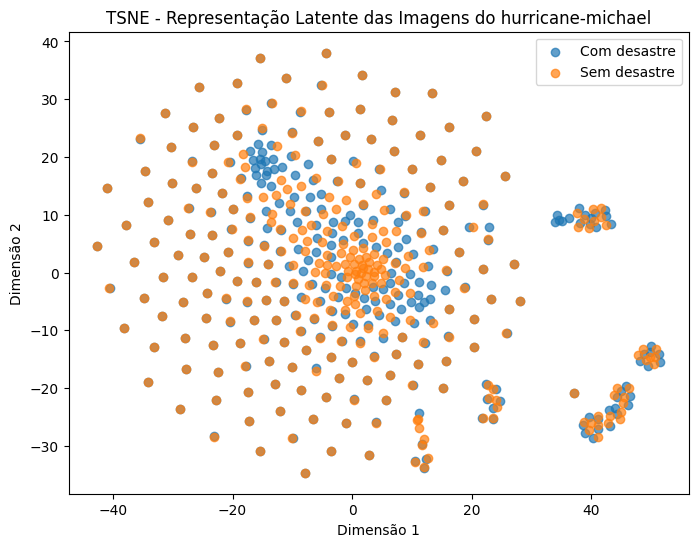

In [81]:
import os
import pandas as pd
import torch
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.manifold import TSNE
import numpy as np

# Define funções de encoding e decodificação (copiadas do seu código)
def pil_to_latent(input_im):
    # Single image -> single latent in a batch (so size 1, 4, 64, 64)
    with torch.no_grad():
        latent = vae.encode(tfms.ToTensor()(input_im).unsqueeze(0).to(torch_device) * 2 - 1)  # Note scaling
    return 0.18215 * latent.latent_dist.sample()

# Caminho da pasta de imagens
image_folder = "/content/hurricane-harvey_samples"

# Inicializa uma lista para armazenar os espaços latentes e labels
latents = []
labels = []

# Processa cada imagem do dataset
for idx, row in filtered_df.iterrows():
    image_path = os.path.join(image_folder, row["Image Name"])
    if os.path.exists(image_path):
        input_image = Image.open(image_path).resize((512, 512))
        latent = pil_to_latent(input_image)
        latents.append(latent.cpu().numpy().flatten())  # Achata para vetor 1D
        labels.append(row["Disaster Status"])
    else:
        print(f"Imagem não encontrada: {image_path}")

# Converte os espaços latentes para um array numpy
latents_array = np.array(latents)

# Aplica TSNE para reduzir dimensões
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(latents_array)

# Gera o gráfico TSNE
plt.figure(figsize=(8, 6))
for label in np.unique(labels):
    indices = [i for i, lbl in enumerate(labels) if lbl == label]
    plt.scatter(
        tsne_results[indices, 0],
        tsne_results[indices, 1],
        label=label,
        alpha=0.7
    )

plt.title("TSNE - Representação Latente das Imagens do hurricane-michael")
plt.legend()
plt.xlabel("Dimensão 1")
plt.ylabel("Dimensão 2")
plt.show()


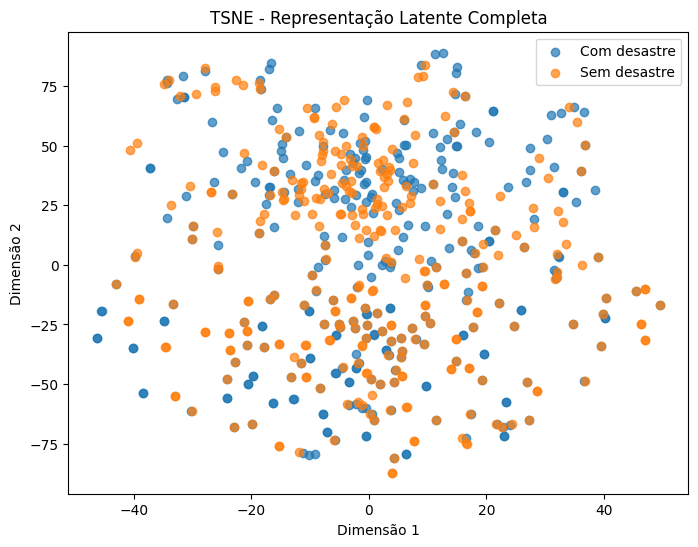

In [82]:
# Mantém os canais e achatam apenas as dimensões espaciais
latents_flattened = [latent.reshape(4, -1) for latent in latents]
latents_flattened_array = np.vstack(latents_flattened)

# Aplica TSNE
tsne_full = TSNE(n_components=2, random_state=42)
tsne_full_results = tsne_full.fit_transform(latents_flattened_array)

# Gráfico TSNE
plt.figure(figsize=(8, 6))
for label in np.unique(labels):
    indices = [i for i, lbl in enumerate(labels) if lbl == label]
    plt.scatter(
        tsne_full_results[indices, 0],
        tsne_full_results[indices, 1],
        label=label,
        alpha=0.7
    )

plt.title("TSNE - Representação Latente Completa")
plt.legend()
plt.xlabel("Dimensão 1")
plt.ylabel("Dimensão 2")
plt.show()


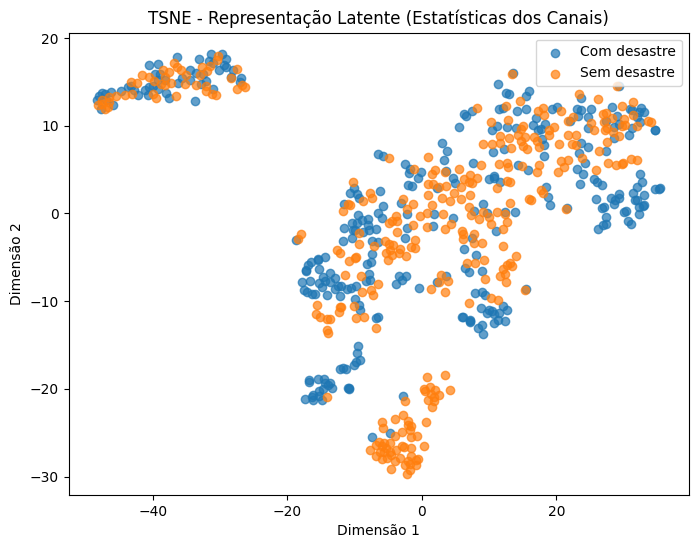

In [83]:
# Calcula as médias e variâncias dos canais do espaço latente
latents_stats = []
for latent in latents:
    latent = latent.reshape(4, 64, 64)  # Retorna à forma original
    stats = []
    for c in range(4):  # Para cada canal
        stats.append(latent[c].mean())  # Média do canal
        stats.append(latent[c].std())   # Desvio padrão do canal
    latents_stats.append(stats)

latents_stats_array = np.array(latents_stats)

# Aplica TSNE usando as estatísticas
tsne_stats = TSNE(n_components=2, random_state=42)
tsne_stats_results = tsne_stats.fit_transform(latents_stats_array)

# Gráfico TSNE com estatísticas
plt.figure(figsize=(8, 6))
for label in np.unique(labels):
    indices = [i for i, lbl in enumerate(labels) if lbl == label]
    plt.scatter(
        tsne_stats_results[indices, 0],
        tsne_stats_results[indices, 1],
        label=label,
        alpha=0.7
    )

plt.title("TSNE - Representação Latente (Estatísticas dos Canais)")
plt.legend()
plt.xlabel("Dimensão 1")
plt.ylabel("Dimensão 2")
plt.show()

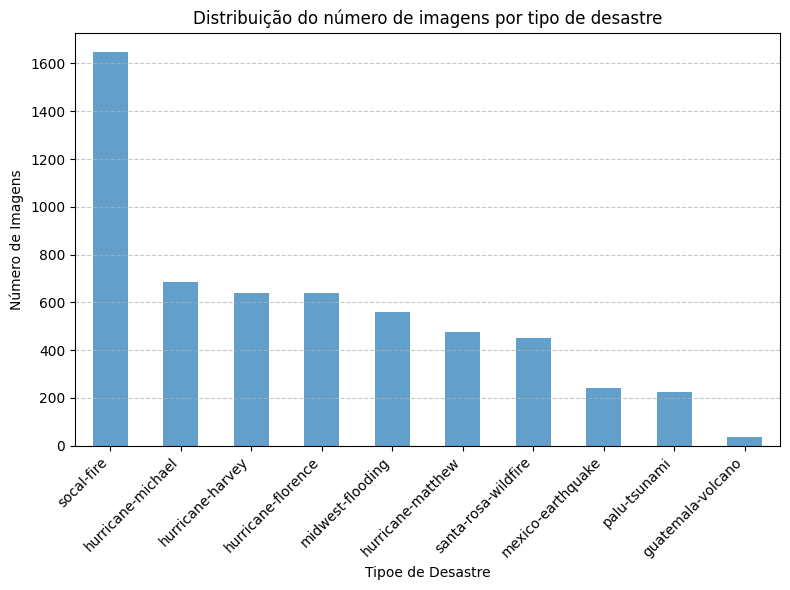

In [35]:

# Contagem do número de imagens para cada tipo de desastre
disaster_counts = image_metadata_df["Disaster Type"].value_counts()

plt.figure(figsize=(8, 6))
disaster_counts.plot(kind="bar", alpha=0.7)

# Personalização do gráfico
plt.title("Distribuição do número de imagens por tipo de desastre")
plt.xlabel("Tipoe de Desastre")
plt.ylabel("Número de Imagens")
plt.xticks(rotation=45, ha="right")  # Rotaciona as labels do eixo X para evitar sobreposição
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()  # Ajusta o layout para evitar cortes nas labels
plt.show()


In [8]:
def pil_to_latent(input_im):
    # Single image -> single latent in a batch (so size 1, 4, 64, 64)
    with torch.no_grad():
        latent = vae.encode(tfms.ToTensor()(input_im).unsqueeze(0).to(torch_device)*2-1) # Note scaling
    return 0.18215 * latent.latent_dist.sample()

def latents_to_pil(latents):
    # bath of latents -> list of images
    latents = (1 / 0.18215) * latents
    with torch.no_grad():
        image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    return pil_images

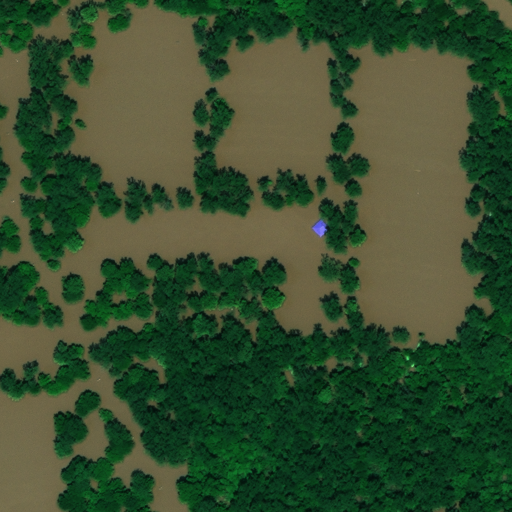

In [9]:
# Load the image with PIL
input_image = Image.open('/content/midwest-flooding_00000010_post_disaster.png').resize((512, 512))
input_image

In [10]:
# Encode to the latent space
encoded = pil_to_latent(input_image)
encoded.shape

torch.Size([1, 4, 64, 64])

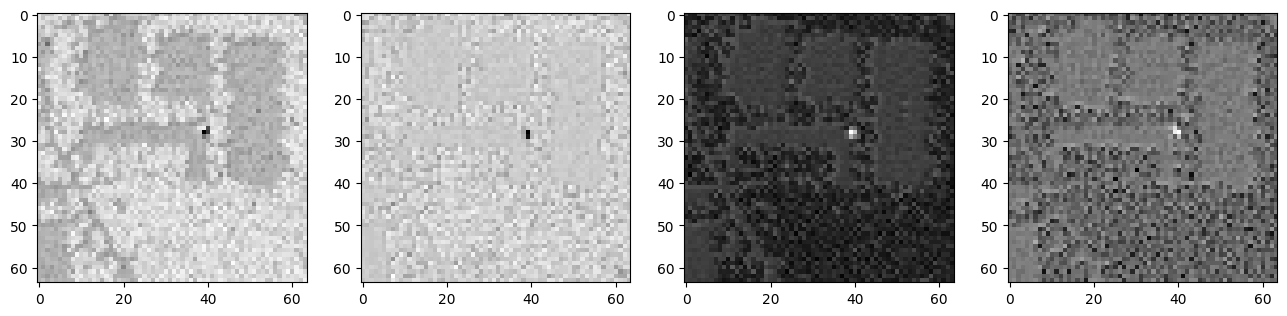

In [11]:

# Let's visualize the four channels of this latent representation:
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for c in range(4):
    axs[c].imshow(encoded[0][c].cpu(), cmap='Greys')

In [14]:
encoded

tensor([[[[-0.3837, -0.5028,  0.1780,  ..., -0.2146,  0.1376, -1.0936],
          [-0.5219, -0.1776,  0.2976,  ..., -0.3692, -0.9262, -0.9578],
          [ 0.4162,  0.3539, -0.0621,  ..., -0.7058, -1.0676, -0.3588],
          ...,
          [-0.9531,  0.7036,  0.9771,  ..., -0.4557, -0.3894, -0.8509],
          [ 1.1324, -0.5798,  1.3796,  ..., -0.2301,  0.8829,  0.1572],
          [-0.7414, -0.0163, -0.4532,  ..., -1.0295, -1.4280, -1.0824]],

         [[-1.1012,  0.2402,  0.1771,  ..., -0.6264, -0.5659, -0.0213],
          [ 0.2636,  0.7048, -0.2351,  ..., -0.1852, -0.2207, -0.2511],
          [ 0.4944,  0.4144, -0.8971,  ..., -0.2924, -0.4847, -0.0255],
          ...,
          [-0.3972,  0.4666, -0.2563,  ..., -0.3467, -0.7777, -0.2970],
          [ 0.0134, -0.2326, -0.7378,  ...,  0.5188,  0.1014, -0.9002],
          [-0.9918,  0.3389,  1.0468,  ..., -0.0207,  0.5793,  0.5432]],

         [[ 0.9102,  1.6304,  0.0795,  ...,  1.4287,  0.2085,  0.9008],
          [ 0.5124, -0.1808,  